In [1]:
import os

DATA_URL='https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
DATASET_DIR="dataset"

DATA_FILE=os.path.join(DATASET_DIR, "online_retail.xlsx")

FULL_COL=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

# [1] Getting Dataset

In [2]:
import urllib.request
import pandas as pd


def download_dataset(directory, url, file_path):
    if not os.path.exists(file_path):
      print("[INFO] data not exists, processing download")
      # Create the specified directory if it does not exist
      if not os.path.exists(directory):
          os.makedirs(directory)

      urllib.request.urlretrieve(url, file_path)
    else:
      print("[INFO] data already exists")

In [3]:
# Download Dataset (if not exist)

download_dataset(DATASET_DIR, DATA_URL, DATA_FILE)

[INFO] data already exists


# [2] Pre-process Data

In [4]:
def load_dataset(file_path, names=None):
    # Load the dataset into a pandas DataFrame
    df = pd.read_excel(file_path)
    return df

In [5]:
# Load the dataset into a Pandas DataFrame
df = load_dataset(DATA_FILE, names=FULL_COL)
df['StockCode'] = df['StockCode'].astype('str')

print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [85]:
# Convert the InvoiceNo and StockCode columns into a list of transactions
transactions = df.groupby(['InvoiceNo'])['StockCode'].apply(list).values.tolist()

print(len(transactions))

25900


In [ ]:
print(df["InvoiceNo"].value_counts())

In [6]:
# Create a dictionary mapping the StockCode values to the Description values
name_dict = df[['StockCode', 'Description']].drop_duplicates().set_index('StockCode').to_dict()['Description']

def get_descriptions(stock_codes):
    """
    Returns a list of descriptions for the given stock codes.
    
    Parameters:
        stock_codes (list): A list of stock codes.
    
    Returns:
        list: A list of descriptions for the given stock codes.
    """
    return [name_dict[code] for code in stock_codes]


In [12]:
print(transactions[:5])

for i in transactions[:5]:
  print(get_descriptions(i))

[['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730'], ['22633', '22632'], ['84879', '22745', '22748', '22749', '22310', '84969', '22623', '22622', '21754', '21755', '21777', '48187'], ['22960', '22913', '22912', '22914'], ['21756']]
['CREAM HANGING HEART T-LIGHT HOLDER', 'WHITE MOROCCAN METAL LANTERN', nan, nan, nan, 'SET 7 BABUSHKA NESTING BOXES', 'GLASS STAR FROSTED T-LIGHT HOLDER']
[nan, nan]
['damaged', "POPPY'S PLAYHOUSE BEDROOM ", "POPPY'S PLAYHOUSE KITCHEN", 'FELTCRAFT PRINCESS CHARLOTTE DOLL', 'IVORY KNITTED MUG COSY ', 'check', 'BOX OF VINTAGE JIGSAW BLOCKS ', 'BOX OF VINTAGE ALPHABET BLOCKS', 'HOME BUILDING BLOCK WORD', 'LOVE BUILDING BLOCK WORD', nan, 'DOORMAT NEW ENGLAND']
['JAM MAKING SET WITH JARS', 'RED COAT RACK PARIS FASHION', 'YELLOW COAT RACK PARIS FASHION', 'BLUE COAT RACK PARIS FASHION']
['BATH BUILDING BLOCK WORD']


In [9]:
from mlxtend.preprocessing import TransactionEncoder

# Convert the transactions into a format that can be used by the Apriori and FP-Growth algorithms
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_te = pd.DataFrame(te_ary, columns=te.columns_)

In [82]:
print(df_te.shape)

(25900, 4070)


# [3] Try Apriori Algorithm

In [75]:
import time
from mlxtend.frequent_patterns import apriori

# Run the Apriori algorithm and measure the time
start_time = time.time()

# Run the apriori algorithm to find frequent itemsets
apriori_results = apriori(df_te, min_support=0.01, use_colnames=True)

# measure the time
apriori_time = time.time() - start_time

# Print the apriori_results
print(apriori_results)
print("processed_time:",apriori_time)

       support                       itemsets
0     0.020193                        (15036)
1     0.012587                      (15056BL)
2     0.017876                       (15056N)
3     0.011236                        (16237)
4     0.012510                        (20675)
...        ...                            ...
1082  0.010270         (85099B, 23203, 23199)
1083  0.011429         (85099B, 23203, 23202)
1084  0.010077   (20719, 20724, 20723, 22355)
1085  0.010386  (85099B, 22386, 22411, 21931)
1086  0.011699   (22697, 22423, 22698, 22699)

[1087 rows x 2 columns]
processed_time: 119.78176522254944


In [35]:
# Sort the apriori_results DataFrame by support in descending order
ranked_apriori_rules = apriori_results.sort_values(by='support', ascending=False)

print(ranked_apriori_rules)

temp_value = list(ranked_apriori_rules['itemsets'])[0]
print(temp_value, ":", get_descriptions(temp_value))

       support                itemsets
591   0.086718                (85123A)
245   0.083861                 (22423)
588   0.082432                (85099B)
515   0.065869                 (47566)
17    0.062085                 (20725)
...        ...                     ...
1040  0.010000   (20728, 22383, 20726)
1060  0.010000  (85099B, 21930, 21931)
34    0.010000                 (20982)
45    0.010000                 (21116)
549   0.010000                (84032B)

[1087 rows x 2 columns]
frozenset({'85123A'}) : ['CREAM HANGING HEART T-LIGHT HOLDER']


# [4] Try FP-Growth Algorithm

In [76]:
from mlxtend.frequent_patterns import fpgrowth

# Run the Apriori algorithm and measure the time
start_time = time.time()

# Run the apriori algorithm to find frequent itemsets
fp_growth_results = fpgrowth(df_te, min_support=0.01, use_colnames=True)

# measure the time
fp_growth_time = time.time() - start_time

# Print the fp_growth_results
print(fp_growth_results)
print("processed_time:",fp_growth_time)

       support        itemsets
0     0.086718        (85123A)
1     0.017915        (84029G)
2     0.016911        (84029E)
3     0.014865         (22752)
4     0.013205         (71053)
...        ...             ...
1082  0.010077  (23203, 23344)
1083  0.010039  (22086, 23344)
1084  0.011853  (23293, 23295)
1085  0.010077  (23296, 23293)
1086  0.010463  (22112, 23355)

[1087 rows x 2 columns]
processed_time: 6.398662328720093


In [37]:
# Sort the fp_growth_results DataFrame by support in descending order
ranked_fp_growth_rules = fp_growth_results.sort_values(by='support', ascending=False)

print(ranked_fp_growth_rules)

temp_value = list(ranked_fp_growth_rules['itemsets'])[0]
print(temp_value, ":", get_descriptions(temp_value))

      support               itemsets
0    0.086718               (85123A)
266  0.083861                (22423)
93   0.082432               (85099B)
456  0.065869                (47566)
41   0.062085                (20725)
..        ...                    ...
503  0.010000                (23078)
786  0.010000  (20728, 22383, 20726)
803  0.010000         (22197, 20727)
240  0.010000               (84032B)
192  0.010000                (20982)

[1087 rows x 2 columns]
frozenset({'85123A'}) : ['CREAM HANGING HEART T-LIGHT HOLDER']


# [5] Compare both algorithms 

[119.78176522254944, 6.398662328720093]


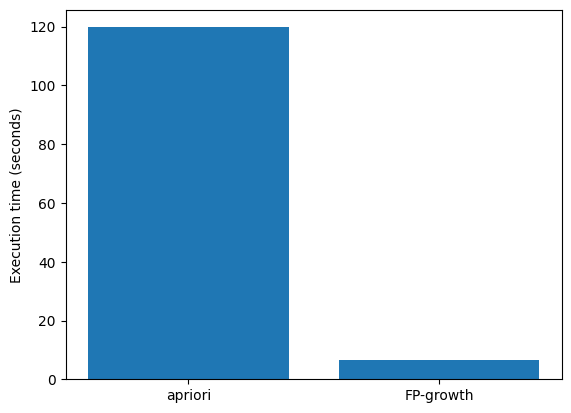

1771.9813465529296 %


In [80]:
import matplotlib.pyplot as plt

algorithms = ["Apriori", "FP-Growth"]

times = [apriori_time, fp_growth_time]
num_frequent_itemsets = [len(apriori_results), len(fp_growth_results)]

print(times)

# Create a line plot to compare the execution time of the two pieces of code
plt.bar(["apriori", "FP-growth"], times)
plt.ylabel("Execution time (seconds)")
plt.show()

print((times[0] - times[1]) / times[1] * 100, "%")

In [70]:
from mlxtend.frequent_patterns import association_rules

# Generate association rules using the Apriori algorithm
apriori_rules_lift = association_rules(apriori_results, metric="lift", min_threshold=50)

# Generate association rules using the FP-Growth algorithm
fp_growth_rules_lift = association_rules(fp_growth_results, metric="lift", min_threshold=50)

# Compare the association rules in terms of the lift metric
print("Apriori association rules (mean lift):", apriori_rules_lift["lift"].mean(), apriori_rules_lift["lift"].shape)
print("FP-Growth association rules (mean lift):", fp_growth_rules_lift["lift"].mean(), fp_growth_rules_lift["lift"].shape)

mean_lifts=[apriori_rules_lift["lift"].mean(), fp_growth_rules_lift["lift"].mean()]

# You can also compare the association rules in terms of other metrics, such as support or confidence

Apriori association rules (mean lift): 60.26038744595887 (2,)
FP-Growth association rules (mean lift): 60.26038744595887 (2,)


In [71]:
apriori_rules_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(23171),(23172),0.014903,0.012124,0.010888,0.730570,60.260387,0.010707,3.666541
1,(23172),(23171),0.012124,0.014903,0.010888,0.898089,60.260387,0.010707,9.666260


In [72]:
fp_growth_rules_lift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(23171),(23172),0.014903,0.012124,0.010888,0.730570,60.260387,0.010707,3.666541
1,(23172),(23171),0.012124,0.014903,0.010888,0.898089,60.260387,0.010707,9.666260


In [58]:
# Generate association rules using the Apriori algorithm
apriori_rules_confidence = association_rules(apriori_results, metric="confidence", min_threshold=0.88)

# Generate association rules using the FP-Growth algorithm
fp_growth_rules_confidence = association_rules(fp_growth_results, metric="confidence", min_threshold=0.88)

# Compare the association rules in terms of the confidence metric
print("Apriori association rules (mean confidence):", apriori_rules_confidence["confidence"].mean(), apriori_rules_confidence["confidence"].shape)
print("FP-Growth association rules (mean confidence):", fp_growth_rules_confidence["confidence"].mean(), fp_growth_rules_confidence["confidence"].shape)

mean_confidences=[apriori_rules_confidence["confidence"].mean(), fp_growth_rules_confidence["confidence"].mean()]


Apriori association rules (mean confidence): 0.8966515105868123 (4,)
FP-Growth association rules (mean confidence): 0.8966515105868121 (4,)


In [59]:
apriori_rules_confidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(23172),(23171),0.012124,0.014903,0.010888,0.898089,60.260387,0.010707,9.666260
1,"(21086, 21080)",(21094),0.011429,0.020347,0.010232,0.895270,43.999051,0.009999,9.354101
2,"(22699, 22698)",(22697),0.023707,0.040811,0.021197,0.894137,21.909313,0.020229,9.060649
3,"(22699, 22423, 22698)",(22697),0.013012,0.040811,0.011699,0.899110,22.031167,0.011168,9.507258


In [60]:
fp_growth_rules_confidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(21086, 21080)",(21094),0.011429,0.020347,0.010232,0.895270,43.999051,0.009999,9.354101
1,"(22699, 22423, 22698)",(22697),0.013012,0.040811,0.011699,0.899110,22.031167,0.011168,9.507258
2,"(22699, 22698)",(22697),0.023707,0.040811,0.021197,0.894137,21.909313,0.020229,9.060649
3,(23172),(23171),0.012124,0.014903,0.010888,0.898089,60.260387,0.010707,9.666260
